In [22]:
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

"""import numpy as np
import pandas as pd
from datetime import datetime
import matplotlibS
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings"""


'import numpy as np\nimport pandas as pd\nfrom datetime import datetime\nimport matplotlibS\nimport matplotlib.pyplot as plt\nfrom matplotlib import colors\nimport seaborn as sns\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.decomposition import PCA\nfrom yellowbrick.cluster import KElbowVisualizer\nfrom sklearn.cluster import KMeans\nimport matplotlib.pyplot as plt, numpy as np\nfrom mpl_toolkits.mplot3d import Axes3D\nfrom sklearn.cluster import AgglomerativeClustering\nfrom matplotlib.colors import ListedColormap\nfrom sklearn import metrics\nimport warnings'

Taking inspiration from: https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering
classifying customers based on data set

start by loading dataset

In [2]:
main_data = pd.read_csv("marketing_campaign.csv", sep = '\t')
print("number of datapoints", len(main_data))
main_data.head()

number of datapoints 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

Data loading success.

Now seeing more information on datasets.

In [3]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

need to remove data points with null income. we can fill null with data, however, since income is probably an important feature in classifying data, we should not fill with data, but rather preserve data relationships.

In [4]:
main_data = main_data.dropna()

Before proceeding to engineer data, check some data types in possibly object columns. 

In [5]:
print("datatypes in education: ", main_data["Education"].value_counts())
print("datatype in marital status: ", main_data["Marital_Status"].value_counts())
#print("datatype in dt customer: ", main_data["Dt-Customer"].value_counts())


datatypes in education:  Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64
datatype in marital status:  Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


need to standardize these data
1. since printing value_count for dt_customer is error, looking at initial sample of data, need to store date as datetime type
2. education can be broken down to 3 types: undergrad (0), postgrads(1). (since basic education is not alot, it will be grouped with undegrad)
3. marital status can be split into 3 types as well: couple (2), single(1), postcouple(0)


In [6]:
main_data["Dt_Customer"] = pd.to_datetime(main_data["Dt_Customer"], format = "%d-%m-%Y")
main_data.info()

main_data["Education"] = main_data["Education"].replace({"Graduation": 0, "PhD": 1, "Master": 1, "2n Cycle": 1, "Basic": 0})
print(main_data["Education"].value_counts())

main_data["Marital_Status"] = main_data["Marital_Status"].replace({"Married": 2, "Single": 1, "Together": 2, "Divorced": 0, "Widow": 0, "Alone" : 1, "Absurd": 1, "YOLO": 1})
print(main_data["Marital_Status"].value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-null   i


Date standardized.
Now we move on to data cleaning. 
1. add number of children
4. add family size
3. add income per household member
2. add age 
5. how long customer has been patron
6. total amount spent
7. total accepted deals


C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

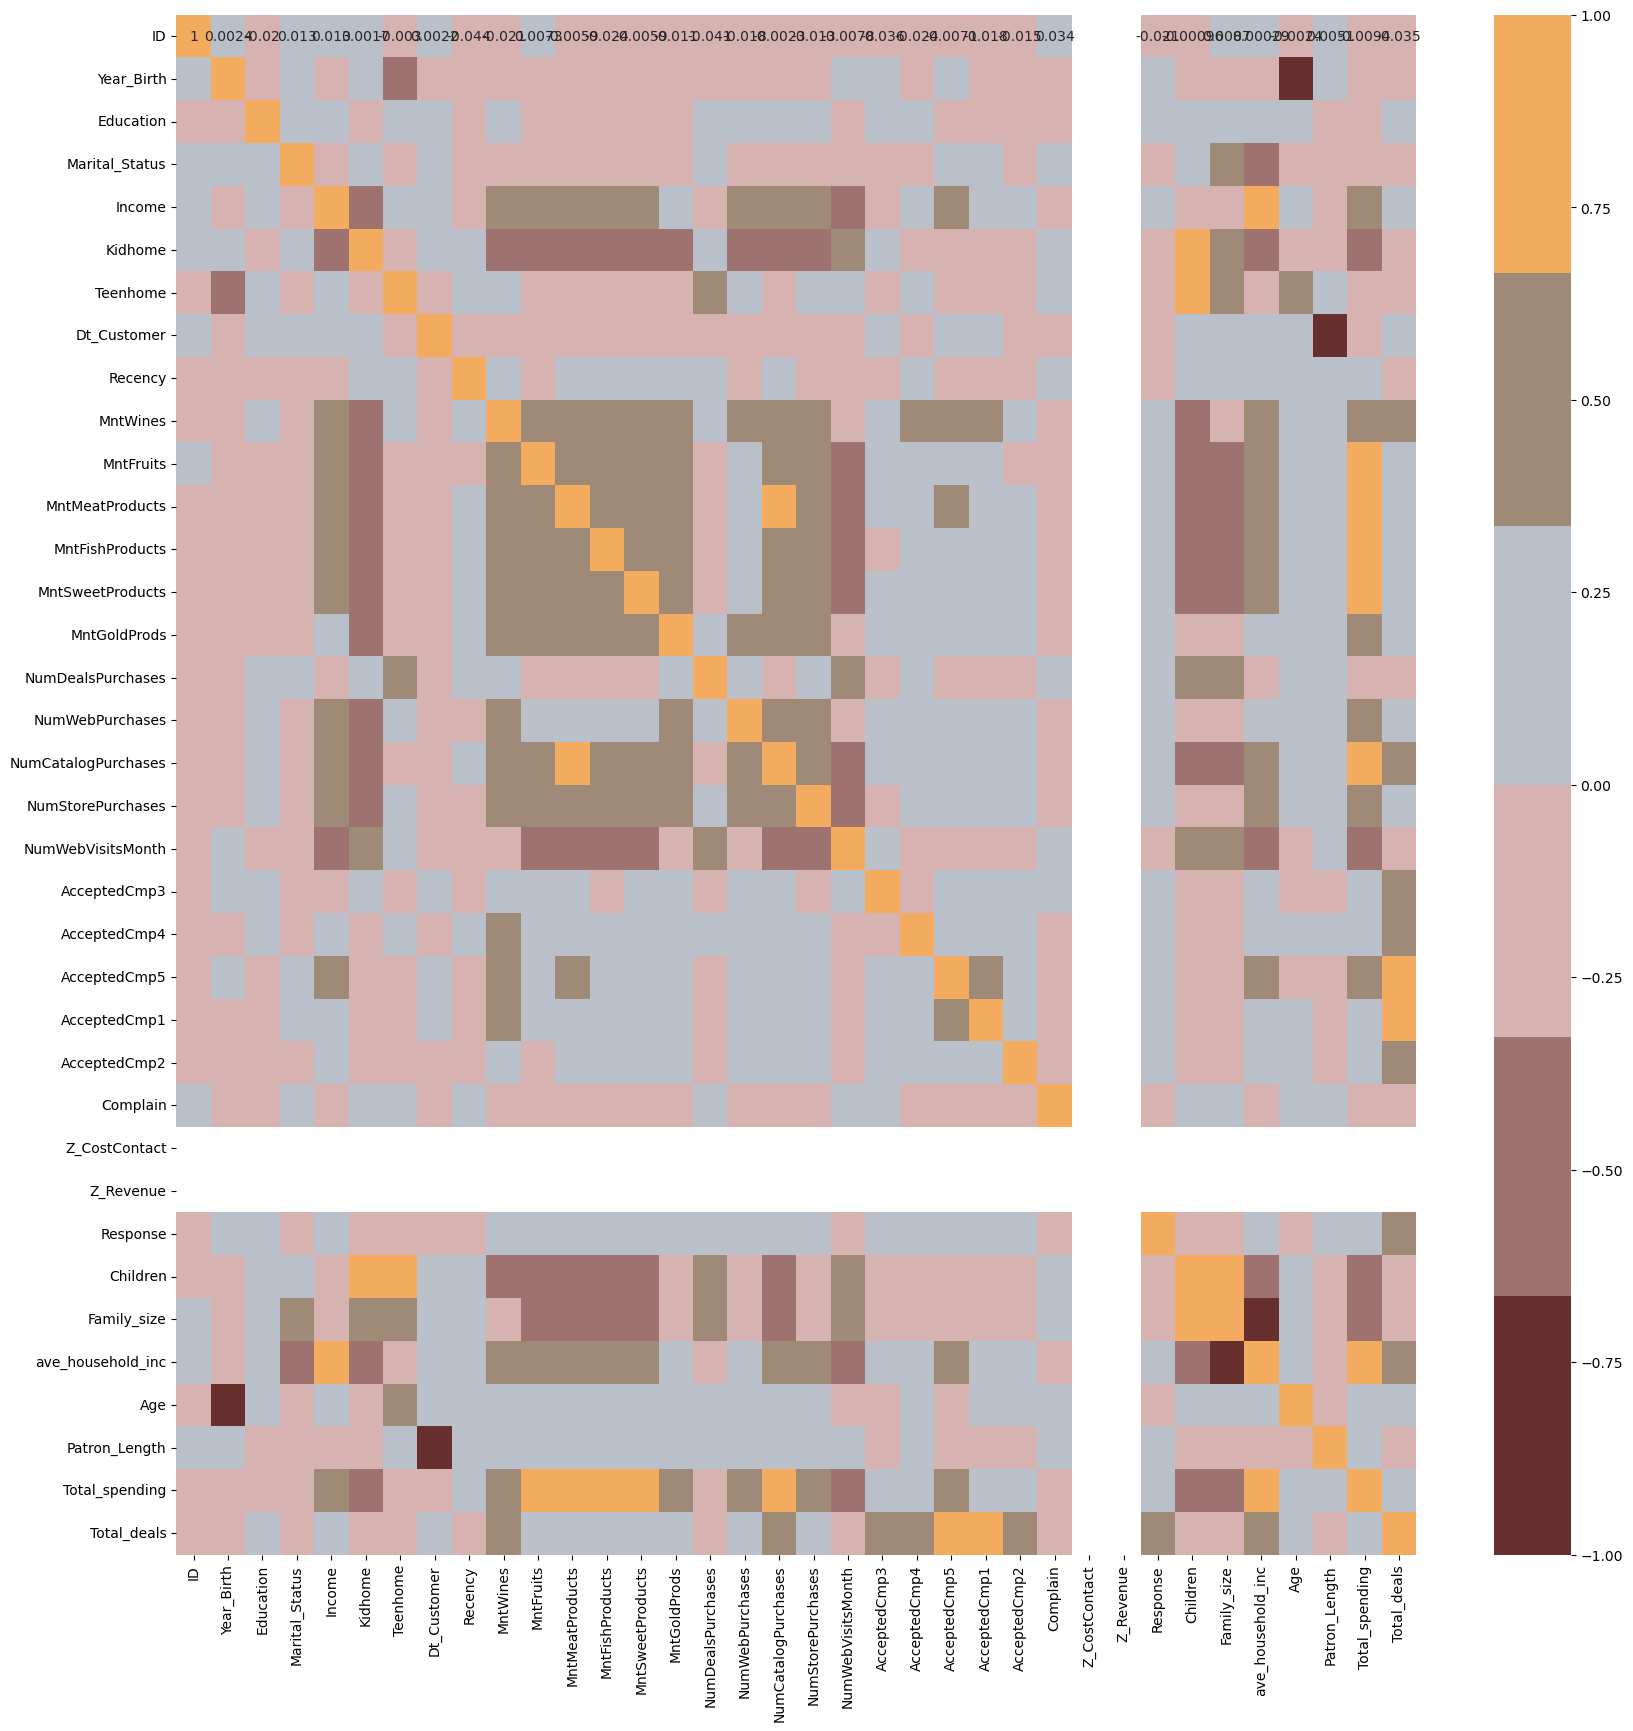

In [7]:
main_data["Children"] = main_data["Kidhome"] + main_data["Teenhome"]
main_data["Family_size"] = main_data["Children"] + main_data["Marital_Status"].replace({2:2, 1:1, 0:1})
main_data["ave_household_inc"] = main_data["Income"]/main_data["Family_size"]

#getting age
max_date = max(main_data["Dt_Customer"])
main_data["Age"] = int(datetime.strftime(max_date, "%Y")) - main_data["Year_Birth"]

#getting length that customer has been patron
Patron_Length = []
for i in main_data["Dt_Customer"]:
    temp= int(datetime.strftime(max_date, "%Y")) - int(datetime.strftime(i, "%Y"))
    Patron_Length.append(temp)
main_data["Patron_Length"] = Patron_Length

main_data["Total_spending"] = main_data["MntFruits"] + main_data["MntFishProducts"] + main_data["MntMeatProducts"] + main_data["MntSweetProducts"] + main_data["MntGoldProds"]
main_data["Total_deals"] = main_data["AcceptedCmp3"] + main_data["AcceptedCmp4"] + main_data["AcceptedCmp5"] + main_data["AcceptedCmp1"] + main_data["AcceptedCmp2"]

#plotting correlation to see which columns to drop
corrmat= main_data.corr()
plt.figure(figsize=(20,20))  
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)


drop features that have relatively high correlation and is not important when analysing clusters


<Axes: >

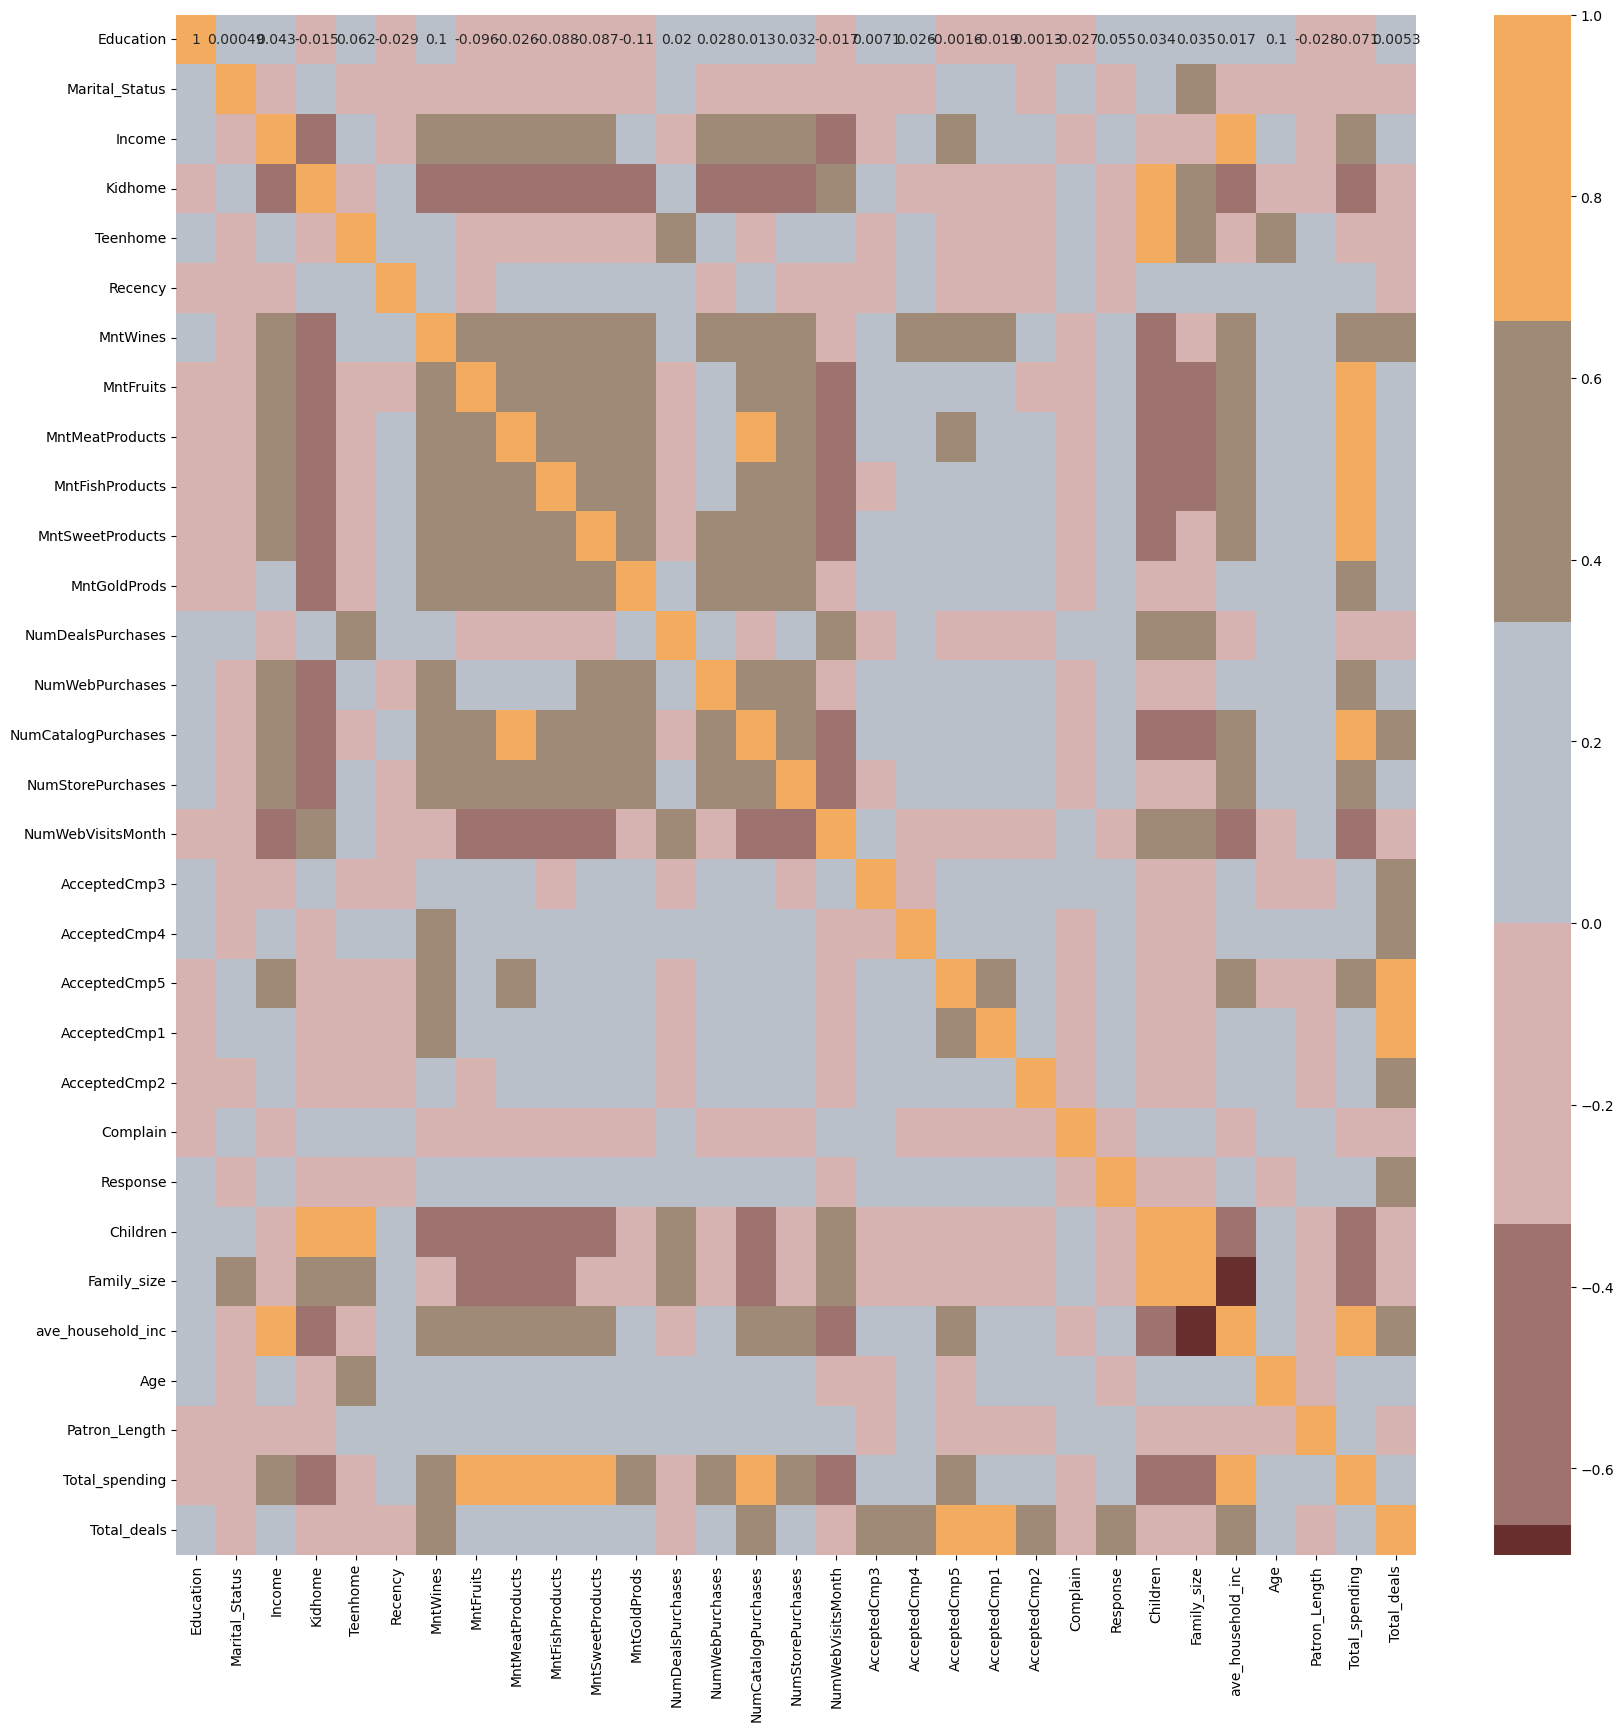

In [8]:
cols_to_drop = ["ID", "Year_Birth", "Dt_Customer", "Z_CostContact", "Z_Revenue"]
useful_data = main_data
useful_data = useful_data.drop(cols_to_drop, axis=1)

corrmat= useful_data.corr()
plt.figure(figsize=(20,20))  
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)


Data correlation look ok, now checking for outliers

Reletive Plot Of Some Selected Features: A Data Subset


C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\A

<Figure size 640x480 with 0 Axes>

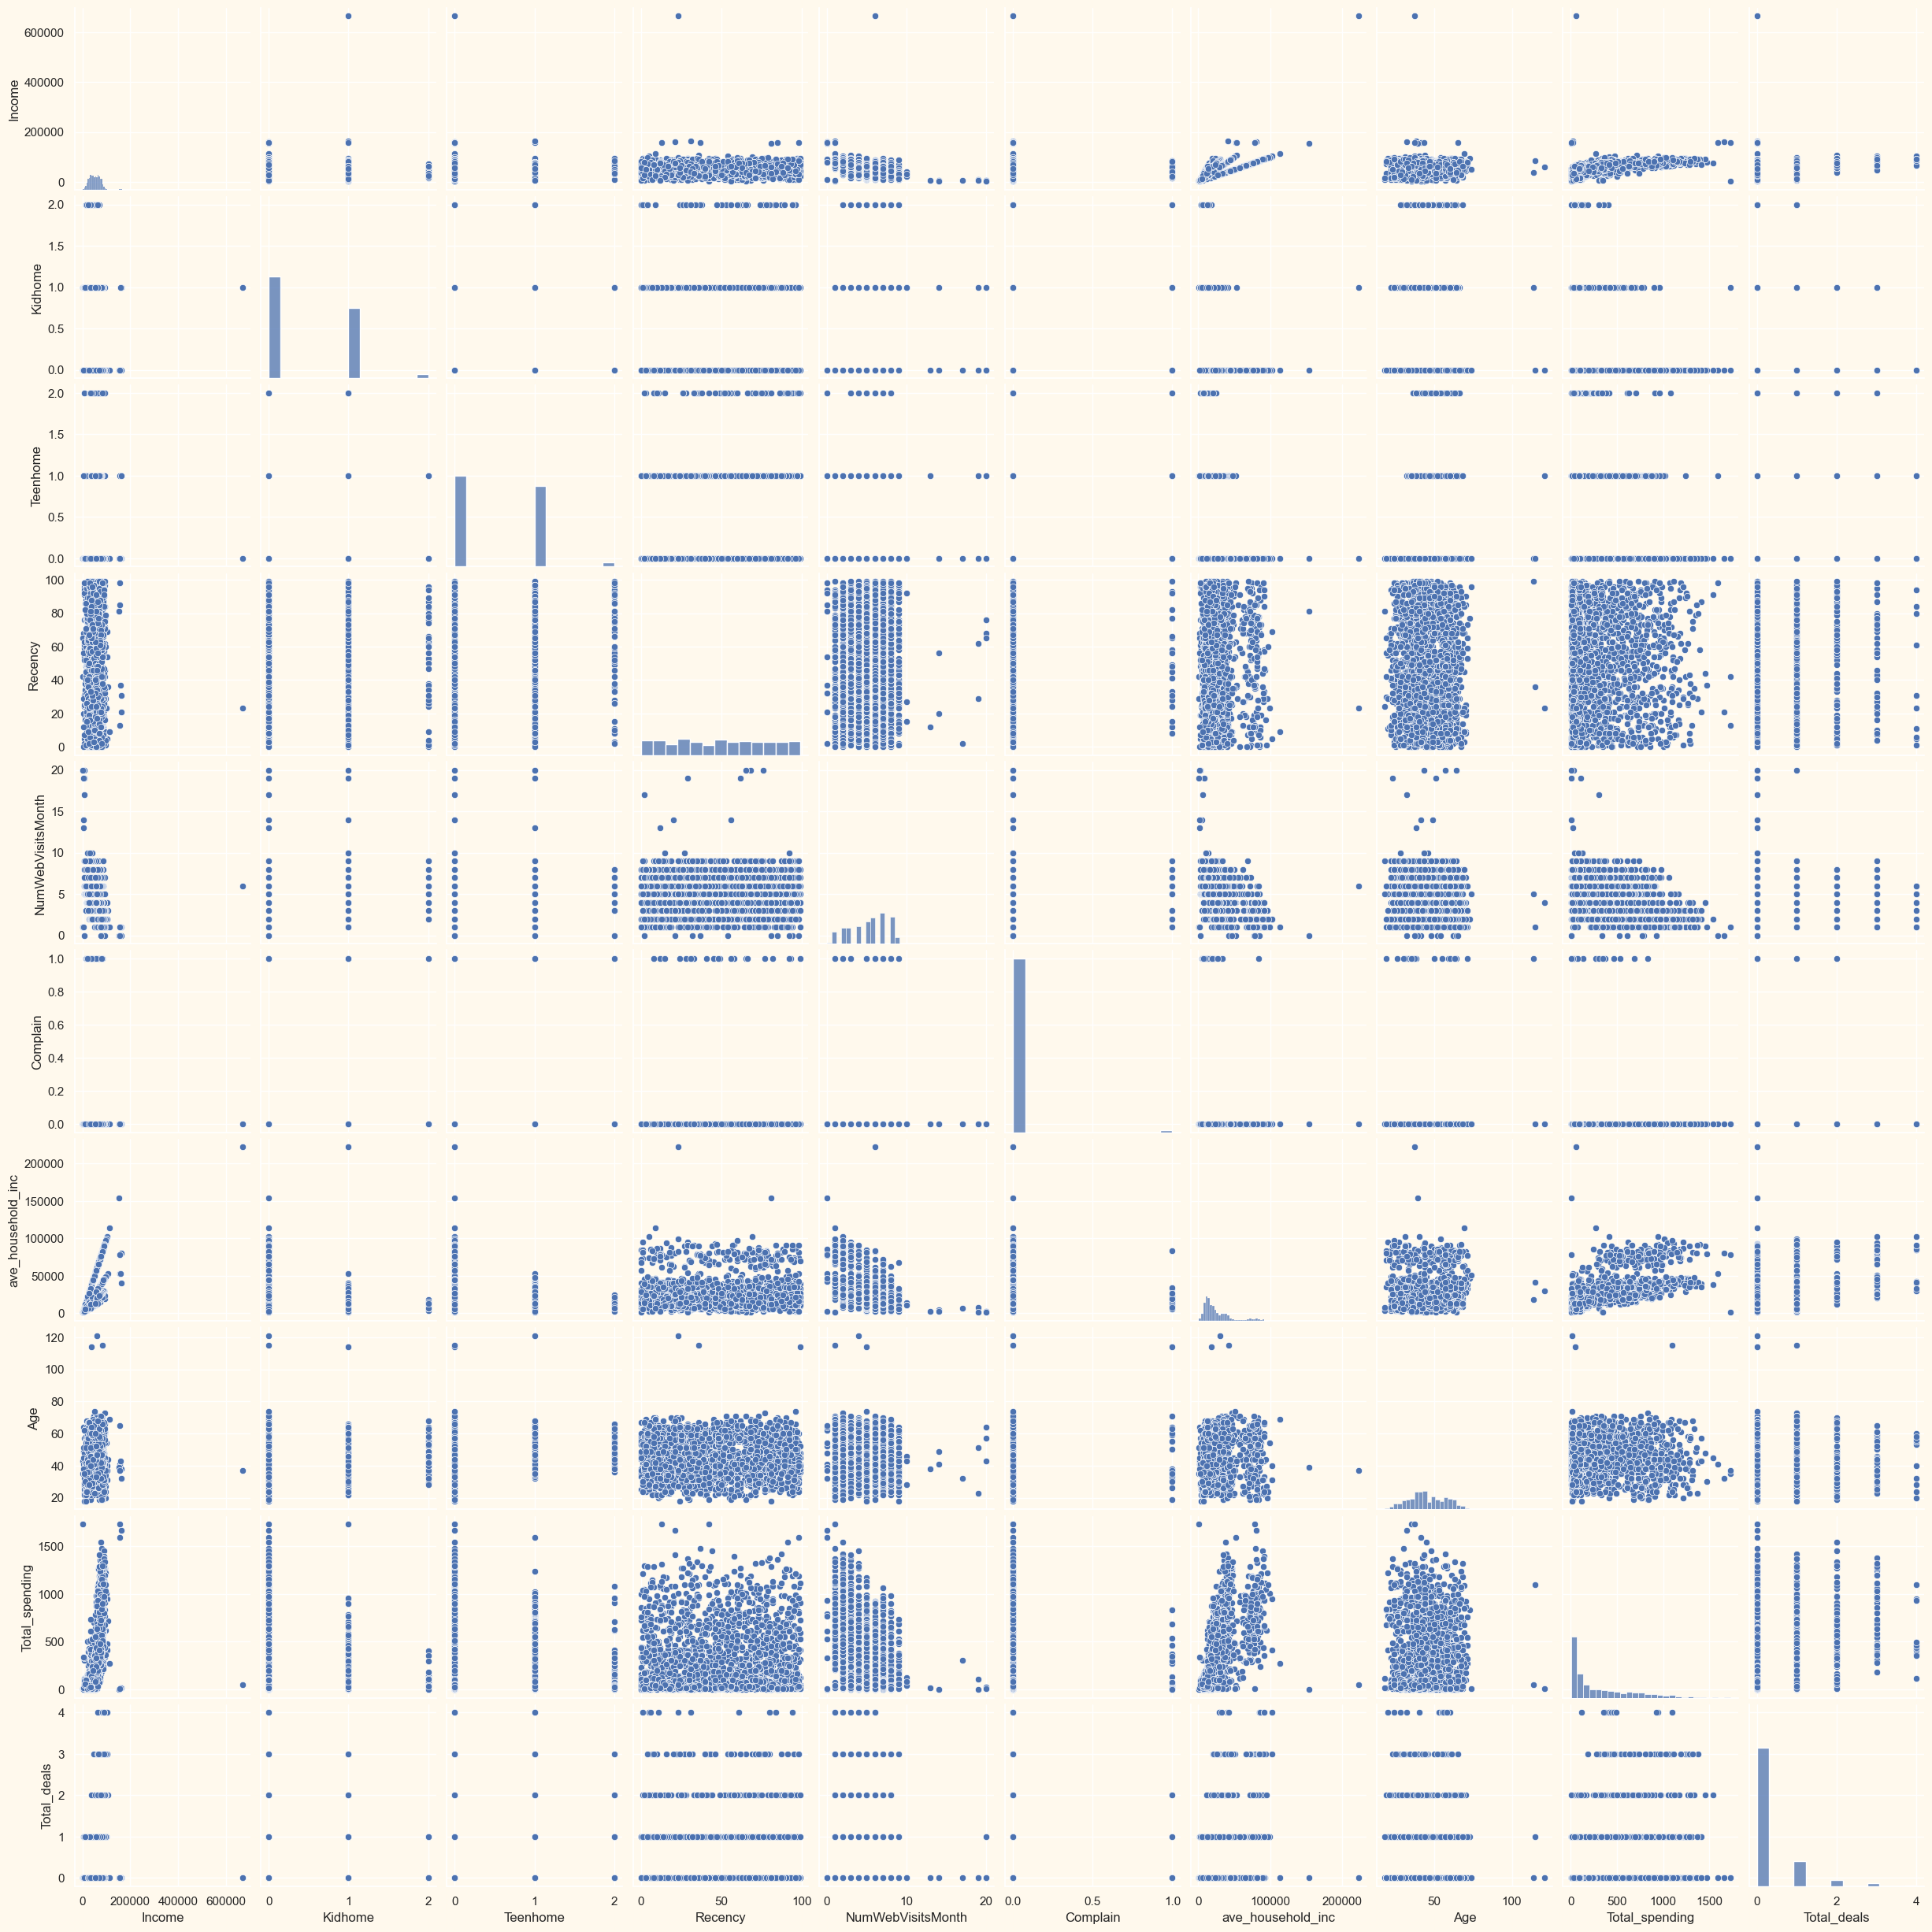

In [9]:
sns.set_theme(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Kidhome", "Teenhome", "Recency", "NumWebVisitsMonth", "Complain", "ave_household_inc", "Age", "Total_spending", "Total_deals"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(useful_data[To_Plot],palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

Some apparent outliers to remove

Reletive Plot Of Some Selected Features: A Data Subset


C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\A

<Figure size 640x480 with 0 Axes>

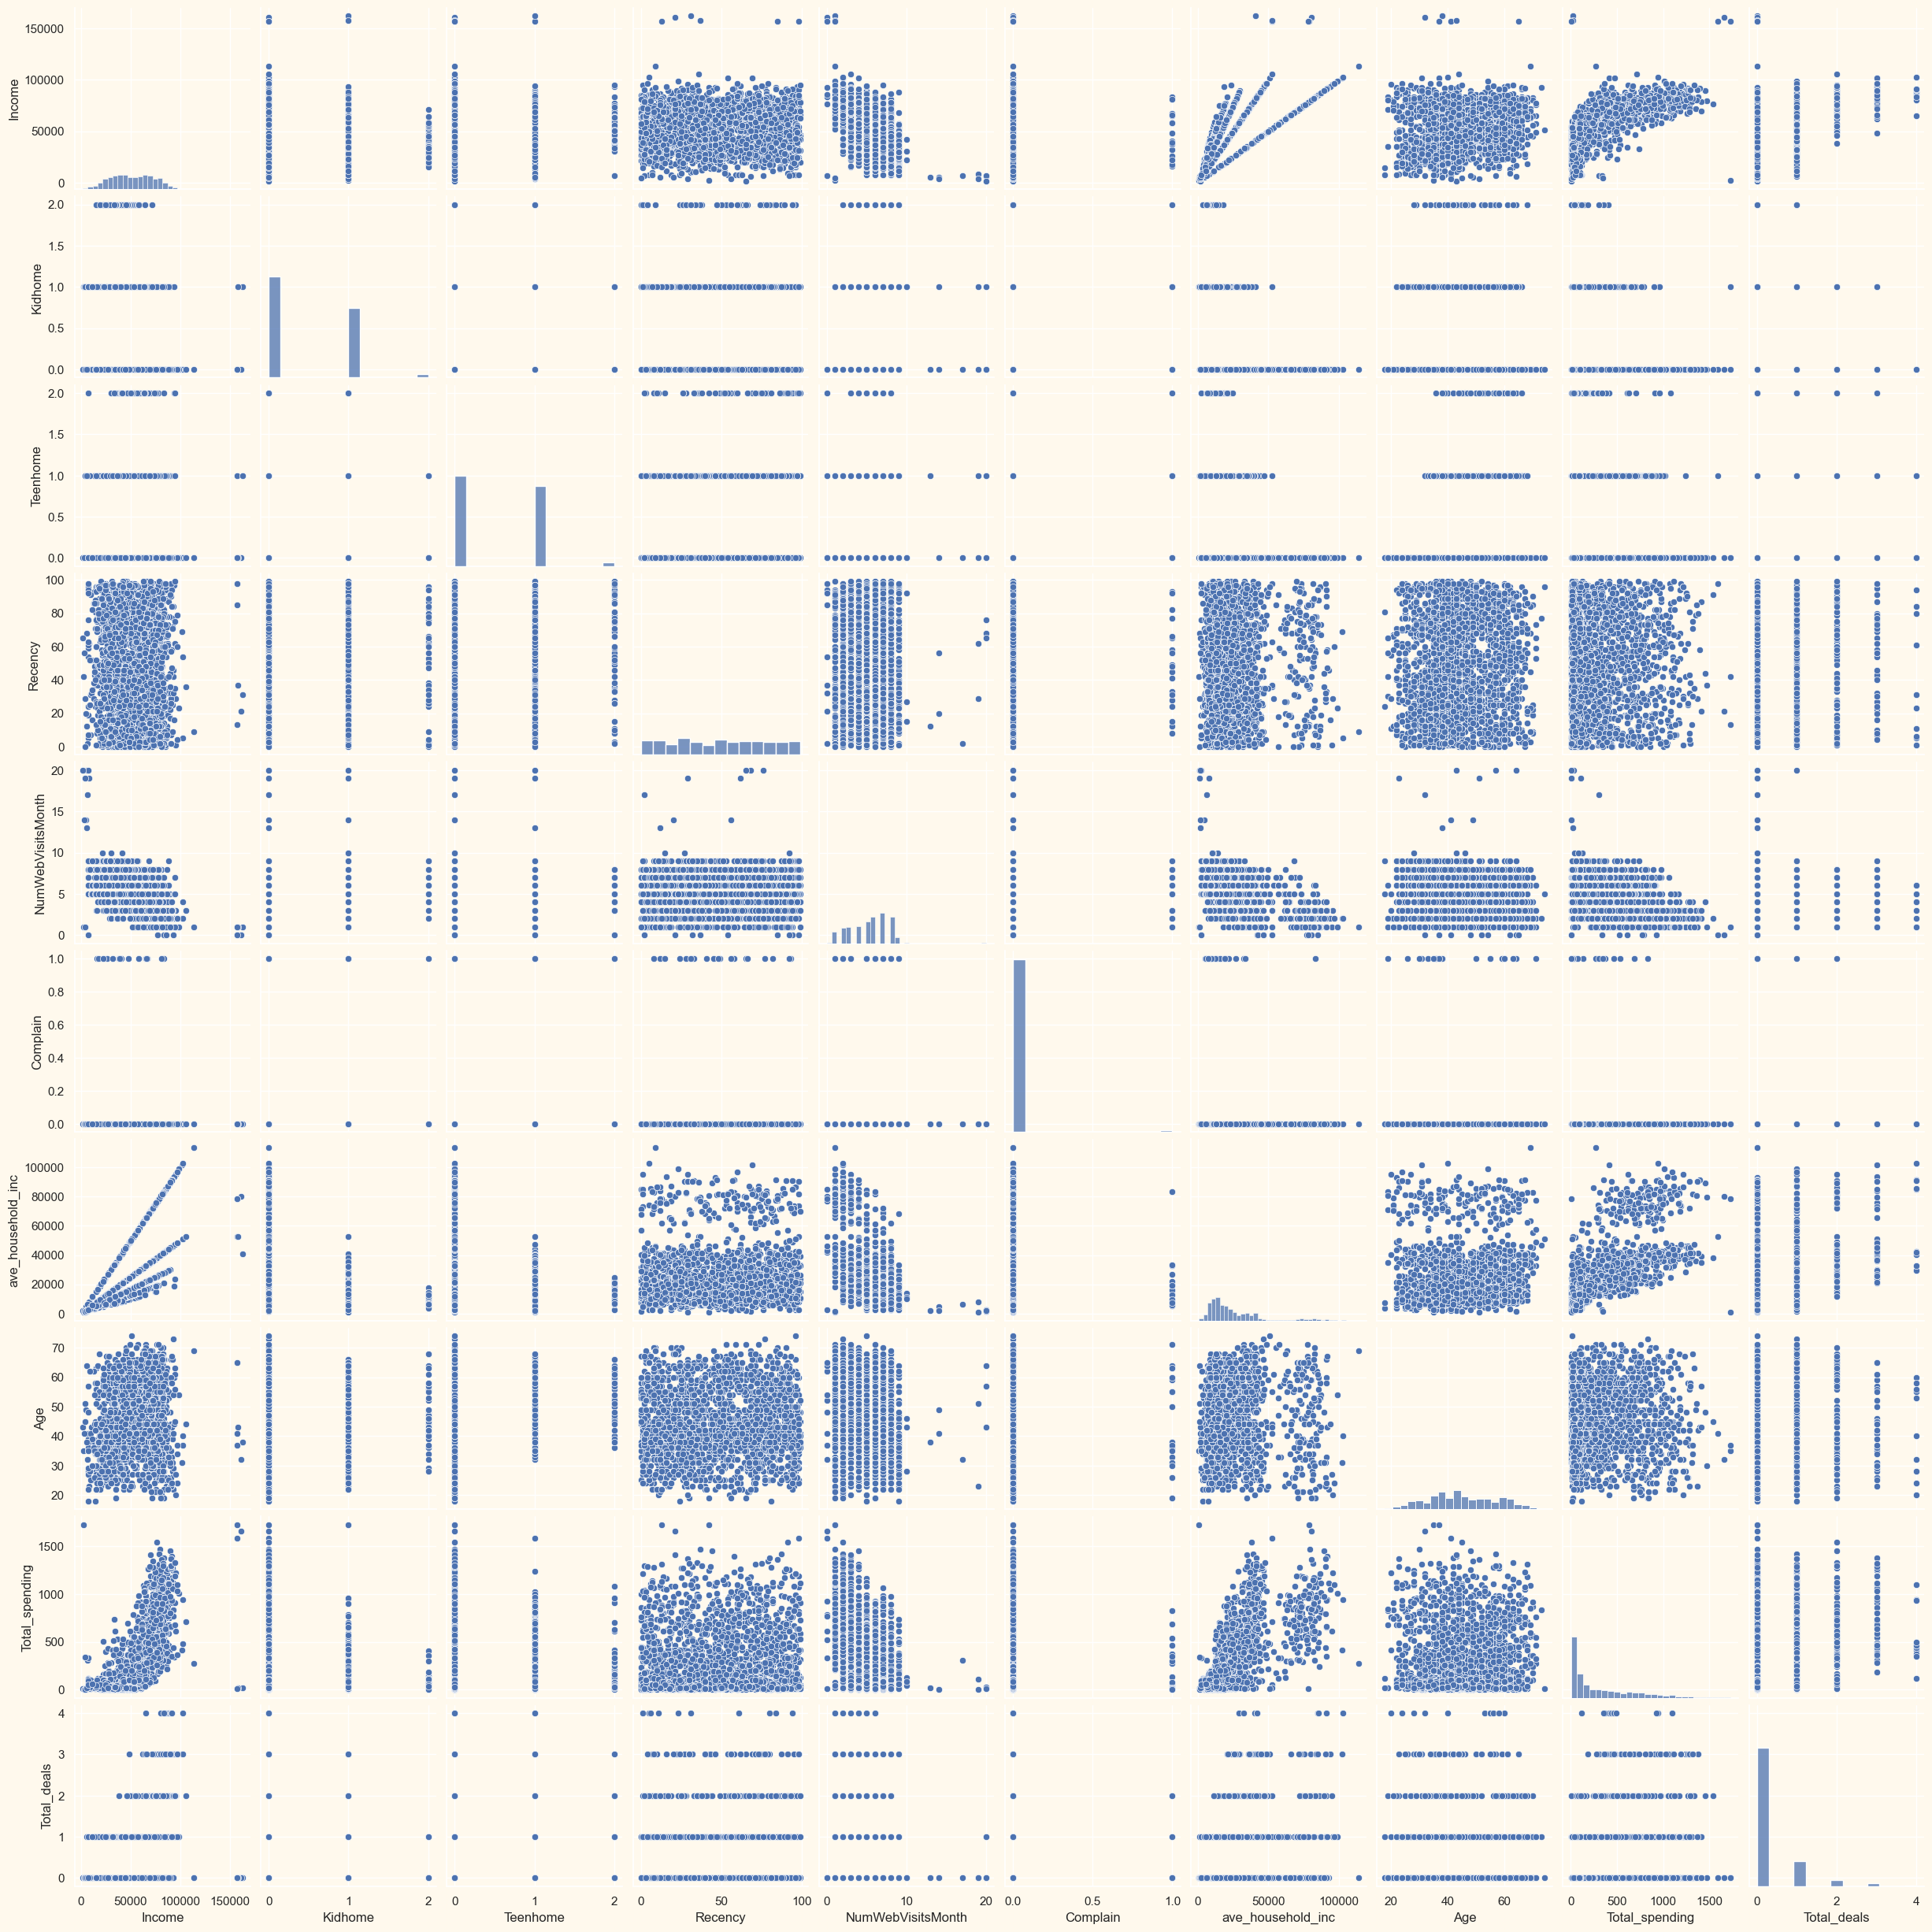

In [10]:
#removing outlier on training dataset
useful_data = useful_data[(useful_data["Income"] < 600000)]
useful_data = useful_data[(useful_data["ave_household_inc"] < 140000)]
useful_data = useful_data[(useful_data["Age"] < 100)]

#also removing outlier on main dataset to allow back referece
main_data = main_data[(main_data["Income"] < 600000)]
main_data = main_data[(main_data["ave_household_inc"] < 140000)]
main_data = main_data[(main_data["Age"] < 100)]

#Plotting following features
To_Plot = [ "Income", "Kidhome", "Teenhome", "Recency", "NumWebVisitsMonth", "Complain", "ave_household_inc", "Age", "Total_spending", "Total_deals"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(useful_data[To_Plot], palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

Now Data looks clean and is ready to be processed.
- since all data are already numerical, do not need encoding
- proceed to scaling data


In [11]:
scaler = StandardScaler()
scaler.fit(useful_data)
useful_data = pd.DataFrame(scaler.transform(useful_data),columns= useful_data.columns )
useful_data.head()


Education  Marital_Status    Income   Kidhome  Teenhome   Recency  \
0  -0.944976       -0.699206  0.290661 -0.823066 -0.930091  0.310869   
1  -0.944976       -0.699206 -0.260004  1.039573  0.907649 -0.380333   
2  -0.944976        0.678641  0.919813 -0.823066 -0.930091 -0.795054   
3  -0.944976        0.678641 -1.179709  1.039573 -0.930091 -0.795054   
4   1.058228        0.678641  0.297898  1.039573 -0.930091  1.555031   

   MntWines  MntFruits  MntMeatProducts  MntFishProducts  ...  AcceptedCmp2  \
0  0.977211   1.551544         1.689786         2.452863  ...     -0.117282   
1 -0.872989  -0.637664        -0.718491        -0.651225  ...     -0.117282   
2  0.357512   0.570175        -0.178859         1.339043  ...     -0.117282   
3 -0.872989  -0.562174        -0.656055        -0.505150  ...     -0.117282   
4 -0.392649   0.419195        -0.218997         0.152186  ...     -0.117282   

   Complain  Response  Children  Family_size  ave_household_inc       Age  \
0 -0.095542  2.374793 -1.265342    -1.759987           1.724279  1.017949   
1 -0.095542 -0.421089  1.404191     0.448487          -0.486263  1.274340   
2 -0.095542 -0.421089 -1.265342    -0.655750           0.567926  0.334240   
3 -0.095542 -0.421089  0.069425     0.448487          -0.826259 -1.289569   
4 -0.095542 -0.421089  0.069425     0.448487          -0.280018 -1.033178   

   Patron_Length  Total_spending  Total_deals  
0       1.498787        2.015580    -0.439278  
1      -1.418306       -0.848213    -0.439278  
2       0.040240        0.141960    -0.439278  
3      -1.418306       -0.771134    -0.439278  
4      -1.418306       -0.157464    -0.439278  

[5 rows x 31 columns]

Scaled data looks good.
now proceeding to dimensionality reduction. the dimensions will be reduced to 3 for easy visualisation and faster clustering algorithm

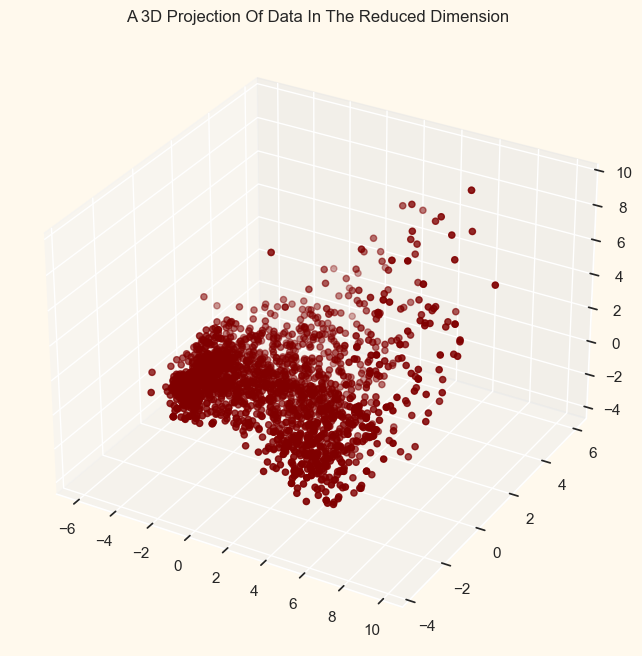

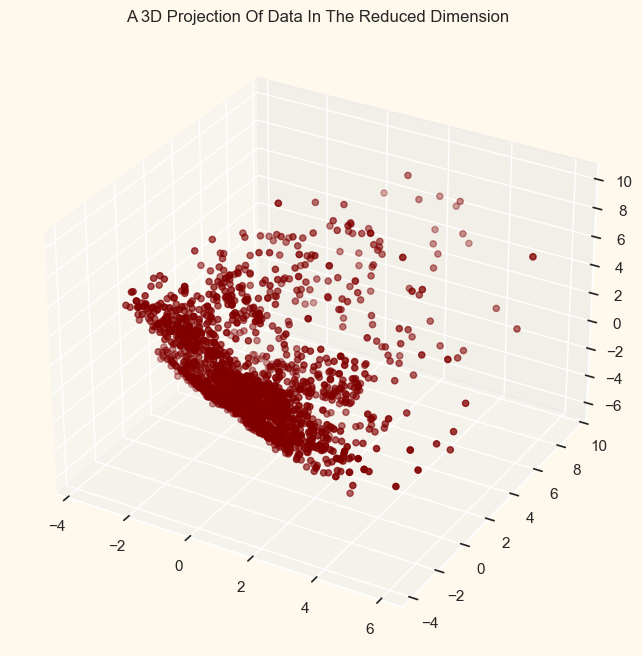

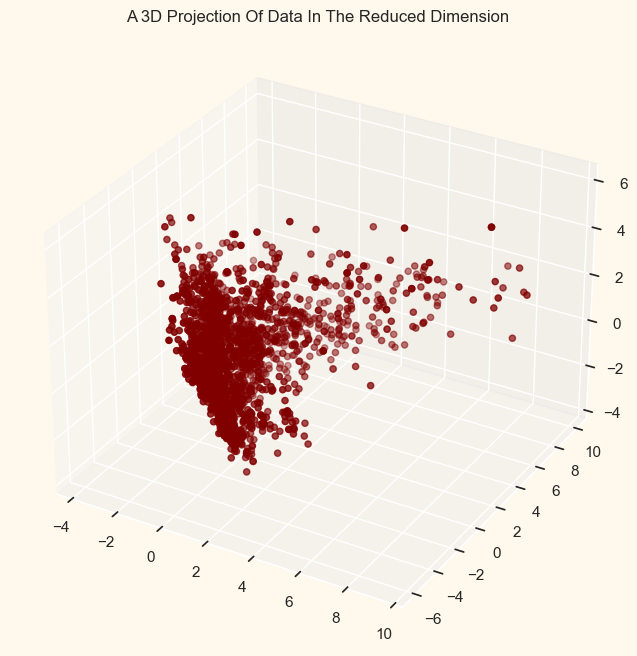

In [16]:
pca = PCA(n_components=3)
pca.fit(useful_data)
training_data = pd.DataFrame(pca.transform(useful_data), columns=(["col1", "col2", "col3"]))
training_data.describe().T

X = training_data["col1"]
Y = training_data["col2"]
Z = training_data["col3"]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X, Y, Z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

X = training_data["col2"]
Y = training_data["col3"]
Z = training_data["col1"]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X, Y, Z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

X = training_data["col3"]
Y = training_data["col1"]
Z = training_data["col2"]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X, Y, Z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

while data does not look as clean as the original kaggle, still looks workable.
Proceed to clustering algorithm itself.
before using the algorithm though, still need decide how many clusters to use. This is done using the elbow method

C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

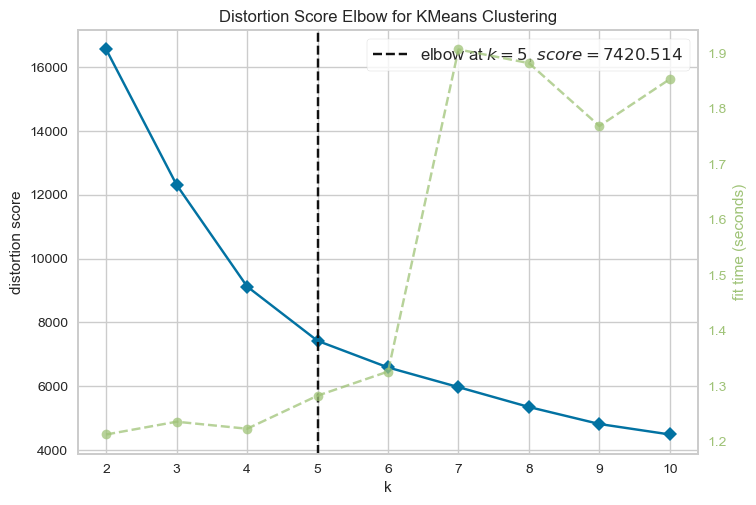

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
Elbow_M = KElbowVisualizer(KMeans(), k = 10)
Elbow_M.fit(training_data)
Elbow_M.show()


Elbow method implies number of cluster to be 6. More than the reference kaggle. expected result since 3d graph is not as clean
proceed to 

In [23]:
Cluster_Model = AgglomerativeClustering(n_clusters=6)
Cluster_output = Cluster_Model.fit_predict(training_data)
training_data["Clusters"] = Cluster_output
useful_data["Clusters"] = Cluster_output
main_data["Clusters"] = Cluster_output

Model trained!
now proceeding to visualise clusters

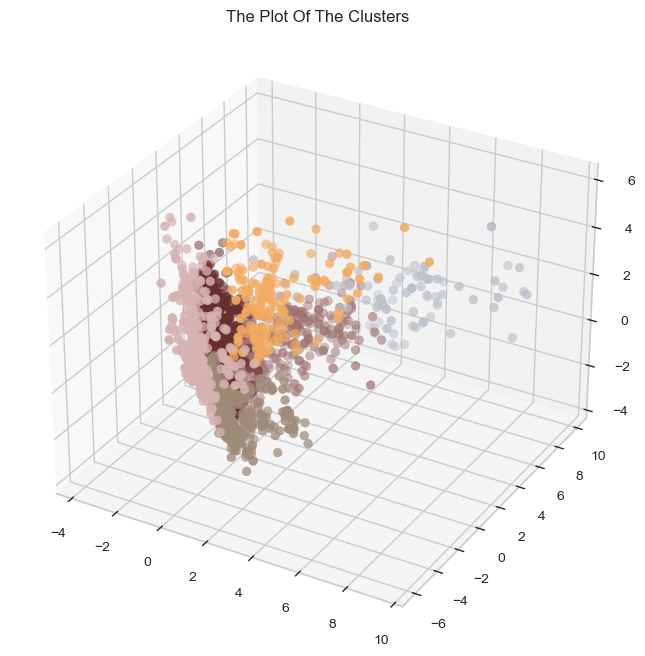

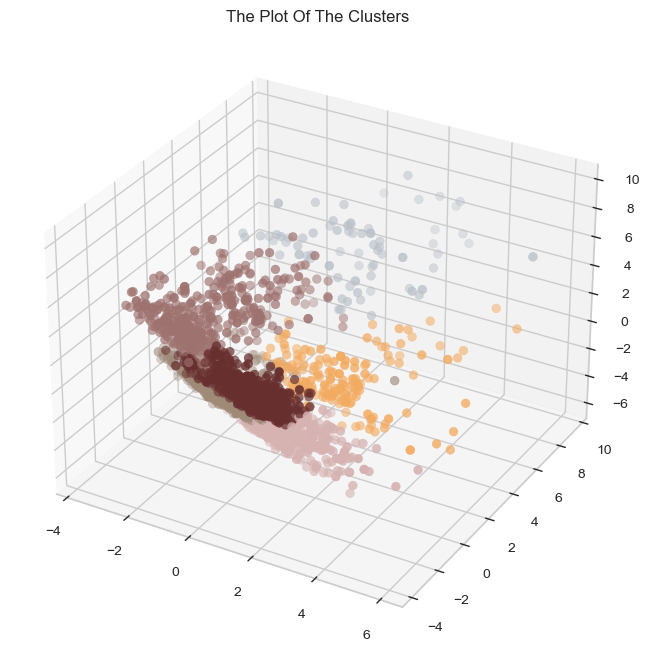

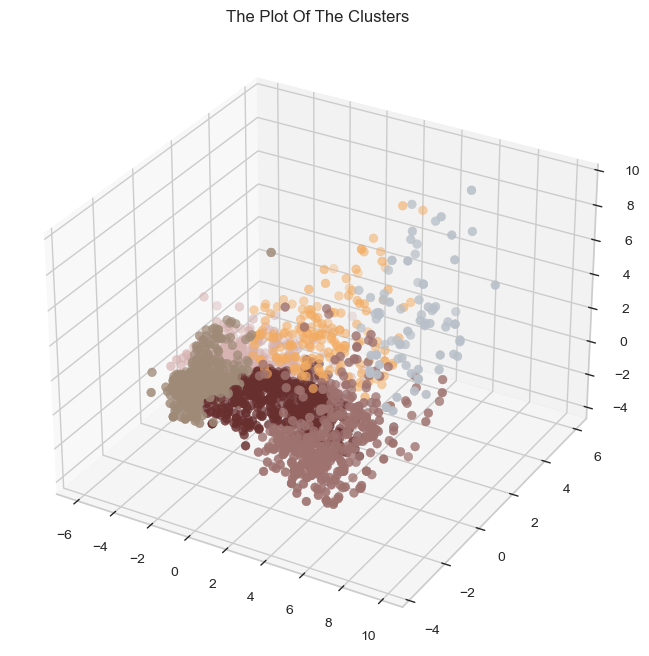

In [28]:
X = training_data["col3"]
Y = training_data["col1"]
Z = training_data["col2"]
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(X, Y, Z, s=40, c=training_data["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

X = training_data["col2"]
Y = training_data["col3"]
Z = training_data["col1"]
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(X, Y, Z, s=40, c=training_data["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

X = training_data["col1"]
Y = training_data["col2"]
Z = training_data["col3"]
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(X, Y, Z, s=40, c=training_data["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

Clustering algorithm looks successful.
proceeding to analyse clusters.
start by looking at distribution of clusters

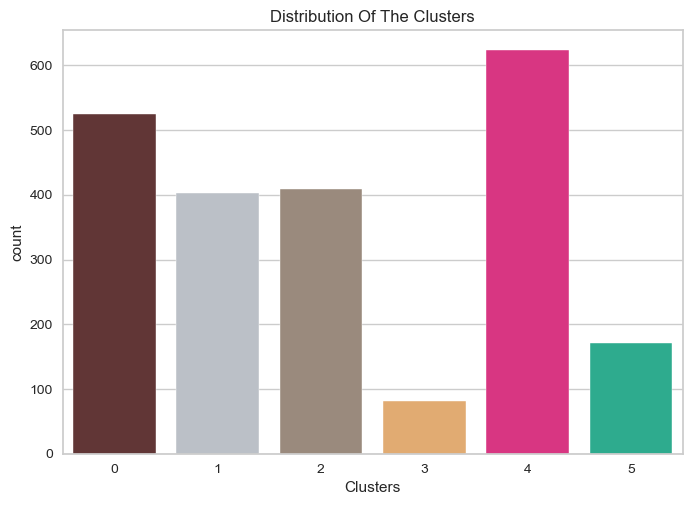

In [44]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60", "#F31B80", "#19C099"]
pl = sns.countplot(x=main_data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

clusters 0, 1, 2 and 4 seem relatively well spread while clusters 3 and 5 look signifcantly lesser. While this could imply bad model, it could also reflect actual demographic of user groups. 
Proceeding to investigate model results further by comparing clusters with spending (the most important factors when grouping customers)

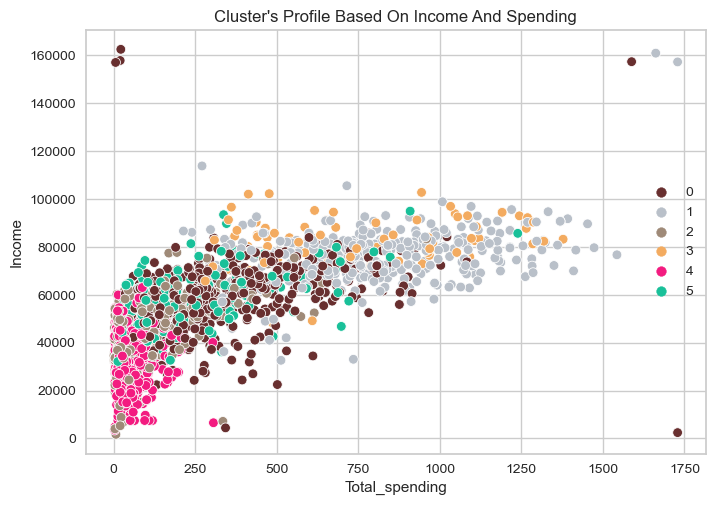

In [45]:
pl = sns.scatterplot(data = main_data,x=main_data["Total_spending"], y=main_data["Income"],hue=main_data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Seems like kaggle's model is better. The difference between kaggle's model and this model is that kaggle removes more features than my model. Initially assuming that these features would give more groups is correct. however, these groups were not as effective in classifying customer in respect to total spending. In this cluster model, it seems like cluster 1 and 3 are the most spread across total spending. However, it could be that these clusters help group our customers in other ways.

to further investigate, look at which cluster spends more on average

C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 45.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size

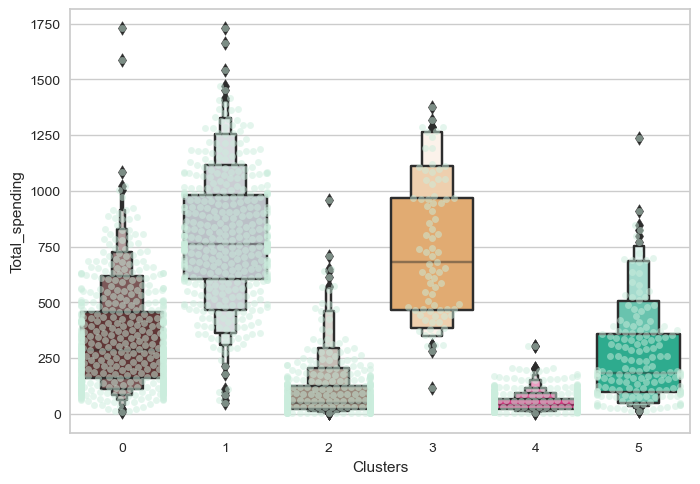

In [46]:
plt.figure()
pl=sns.swarmplot(x=main_data["Clusters"], y=main_data["Total_spending"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=main_data["Clusters"], y=main_data["Total_spending"], palette=pal)
plt.show()

Seems like cluster 1 and 3 are the biggest money makers per customers. cluster 0, has a large quantity of customers and spend decenet amounts. clusters 2, 4, and 5 spend relatively little. According to these clusters, it seems like the company should focus on attracting more customers from cluster 3. Additionally, focusing on cluster groups 1 and 3 follow by 0 might increase the company profits the most. Therefore, we proceed to profiling the customers to determine how to appeal to them most

C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

<Figure size 800x550 with 0 Axes>

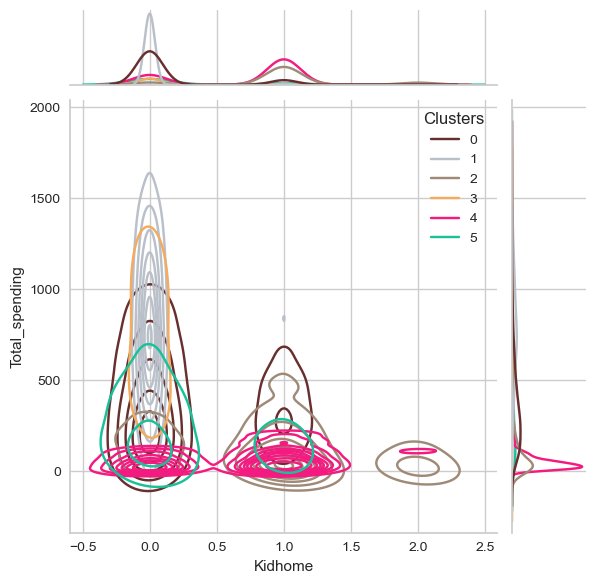

C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

<Figure size 800x550 with 0 Axes>

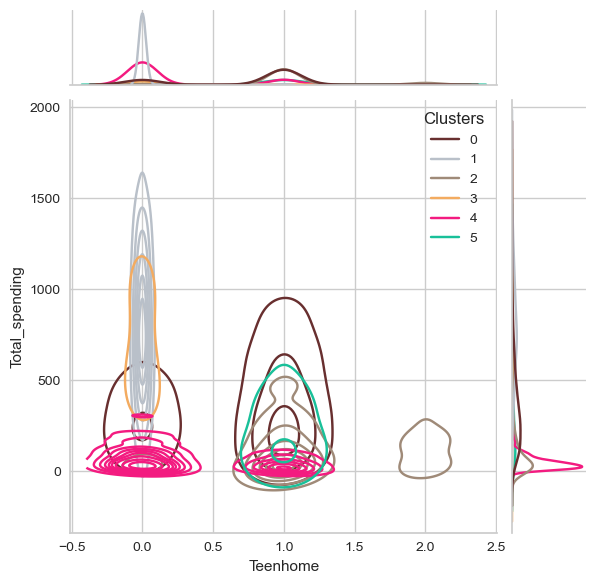

C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

<Figure size 800x550 with 0 Axes>

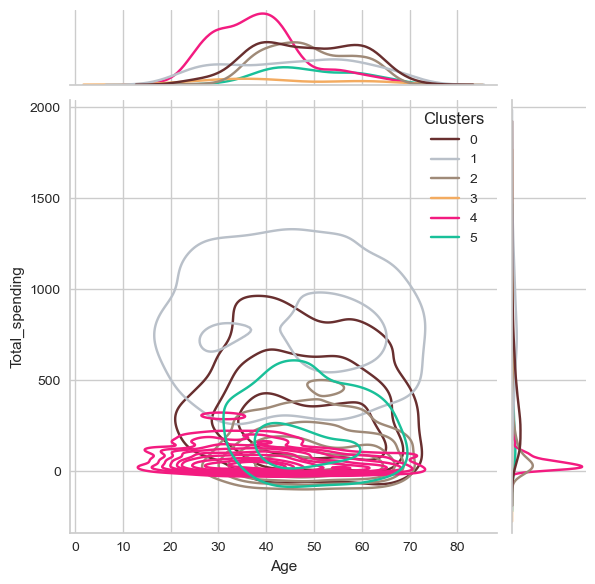

C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

<Figure size 800x550 with 0 Axes>

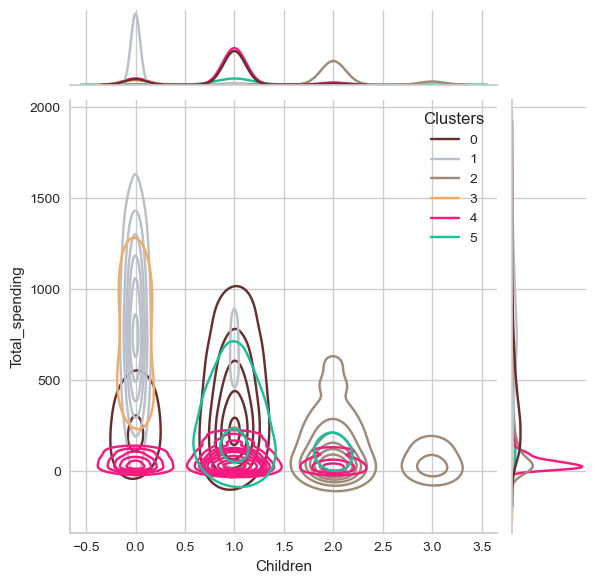

C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

<Figure size 800x550 with 0 Axes>

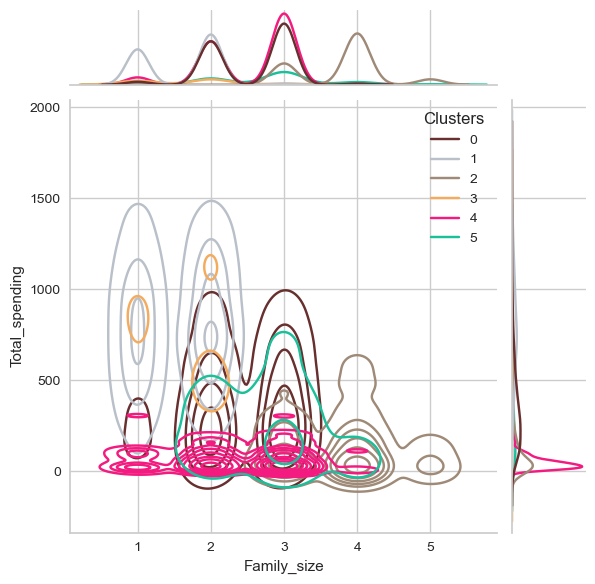

C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

<Figure size 800x550 with 0 Axes>

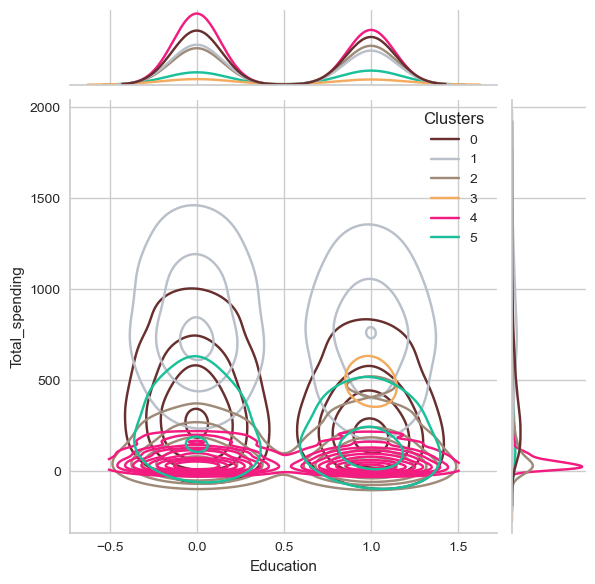

C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

<Figure size 800x550 with 0 Axes>

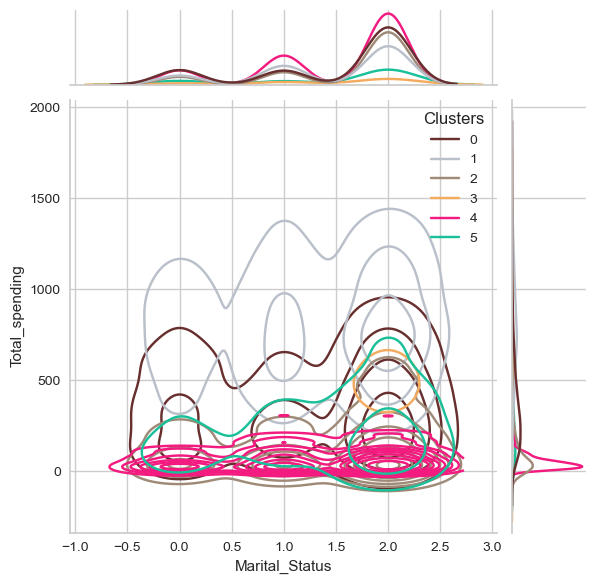

C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kierann.chong\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

<Figure size 800x550 with 0 Axes>

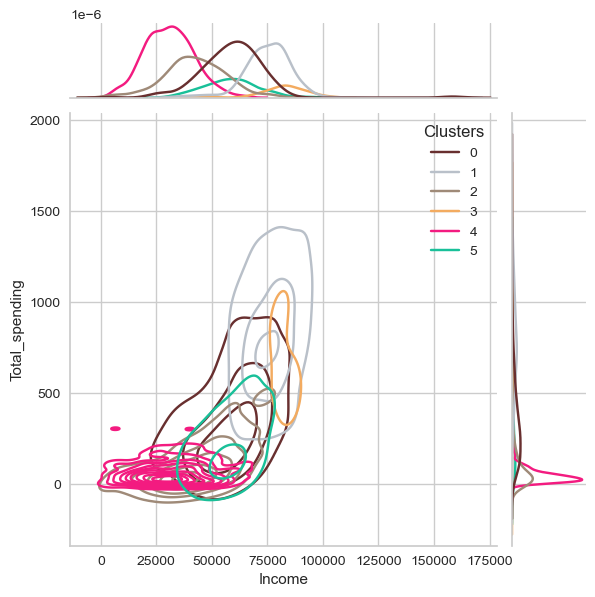

In [47]:
Personal = [ "Kidhome","Teenhome", "Age", "Children", "Family_size", "Education", "Marital_Status", "Income"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=main_data[i], y=main_data["Total_spending"], hue =main_data["Clusters"], kind="kde", palette=pal)
    plt.show()

based on analysis, 
cluster : label
0: family size more than 1, high middle income, married or married before, more teens
1: childless
2: Large family with many kids, middle income
3: High income
4: middle working adults (age 30-40), lower income, more kids
5: high middle income, middle age (40-60)

since cluster 1 and 3 are the biggest spenders, attracting more will quickly increase revenue, as long as there are still new customers in those fields to be gained. To attract these two clusters, the company can focus on high quality, low quantity products that attract the high income and childless. For example: artisanal Small house decorations, or things that surround a more social life such as premium sports equipment. the company can even consider opening a premium bar section within the mart itself. 

since cluster 0 makes up a middle amount of spenders and are already large in quantity, it makes sense to push teen products to the more luxurious end, especially since the group has higher income. This will results in loss of lower income family clusters such as 4 and 2. However, considering that these groups do not provide much revenue to the company in the first place, it would probably be overall more beneficial to move to higher end teen products. 

since cluster 4 has high number of customers but low spending per customer, it might be beneficial to sell more expensive child goods while maintaining quantity. This is tricky since the cluster has lower income. Therefore, the best approach will be to sell huge jumbo size/"value for money" children goods such as large containers of milk, snacks, candy, fresh vegetable and fruits. This would incentivse cluster 4 to spend more per visit while keep them interested in visiting the company. Such a strategy will apply to group 2 as well, perhaps even more effectively than it applies to cluster 4. Therefore, to overall increase total sales from the lowest spending clusters, this strategy can be applied. This would not affect the big ticket customers such as cluster 1 and 3 since they generally do not have children. 

While the analysis in the above section does not apply to the project in classifying items, method to profile customers can be similar to the method to categorize items. Furthermore, if analysis such as the above is possible with the classified items, it might be a added benefit of the clustering algorithm.